# Tensorflow-Lite用のモデルへ変換

In [2]:
import numpy as np
import tensorflow as tf

# Path to the saved best Keras model from K-fold cross-validation
best_hdf5_model_path = '../FINALMODEL_cnn_classifier.hdf5'  # Update this path to your best model's path
tflite_save_path = '../FINALMODEL_cnn_classifier.tflite'

# Load the best Keras model
model = tf.keras.models.load_model(best_hdf5_model_path)

# Convert the model to TensorFlow Lite without optimization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to TFLite format
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)

print(f'TFLite model saved to {tflite_save_path}')

# If you want to perform inference to test the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

# Retrieve input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# You must use a batch of data for input to TFLite model
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

# Set the tensor to point to the input data to be inferred
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print('TFLite Inference Results:', np.squeeze(tflite_results))
print('Predicted Class:', np.argmax(np.squeeze(tflite_results)))




INFO:tensorflow:Assets written to: C:\Users\cathe\AppData\Local\Temp\tmp2rgn3vw3\assets


INFO:tensorflow:Assets written to: C:\Users\cathe\AppData\Local\Temp\tmp2rgn3vw3\assets


TFLite model saved to ../FINALMODEL_cnn_classifier.tflite
TFLite Inference Results: [2.29187546e-12 1.60554930e-10 1.64897790e-06 1.00100150e-09
 3.11994633e-15 4.55655652e-12 1.72621958e-10 4.83173026e-05
 3.17434828e-11 2.99678698e-14 9.66239077e-06 7.28498479e-15
 2.97886923e-11 1.36998685e-14 1.45823398e-08 1.23744152e-01
 8.74022722e-01 2.43104046e-15 1.37364993e-14 1.80998196e-16
 1.36002694e-16 2.96106611e-10 7.62009119e-12 4.53522446e-13
 2.37290542e-15 2.17339862e-03]
Predicted Class: 16


INFO:tensorflow:Assets written to: C:\Users\cathe\AppData\Local\Temp\tmp0fdwfrjz\assets


INFO:tensorflow:Assets written to: C:\Users\cathe\AppData\Local\Temp\tmp0fdwfrjz\assets


TFLite model saved to ../FINALMODEL_cnn_classifier.tflite
Test Accuracy: 0.9950


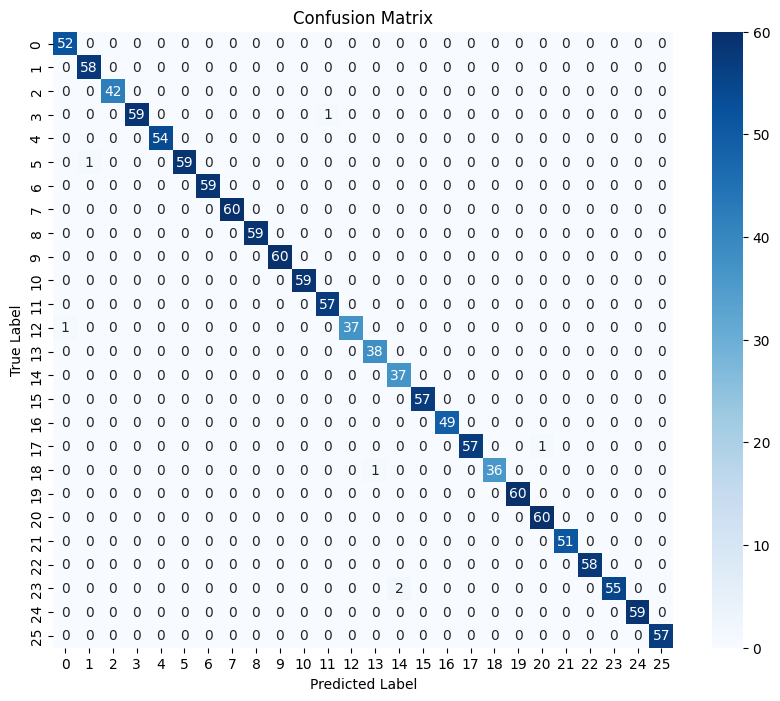

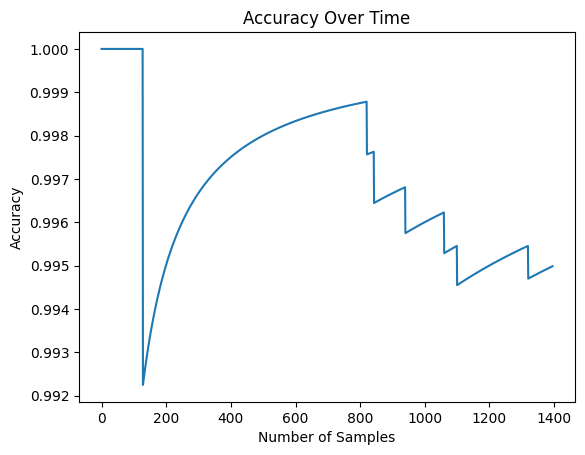

Refinement data saved to ../datasets/refinement_for_model_1.csv


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set TensorFlow logging to DEBUG for detailed logs (optional)
tf.get_logger().setLevel('DEBUG')

# Paths to the model and data
model_save_path = '../FINALMODEL_cnn_classifier.hdf5'
tflite_save_path = '../FINALMODEL_cnn_classifier.tflite'
dataset_path = '../datasets/keypoint_for_testing.csv'
refinement_csv_path = '../datasets/refinement_for_model_1.csv'

# Load the best Keras model
model = load_model(model_save_path)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Convert the model to TensorFlow Lite without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to TFLite format
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved to", tflite_save_path)

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load testing dataset
X_test = np.loadtxt(dataset_path, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_test = np.loadtxt(dataset_path, delimiter=',', dtype='int32', usecols=(0))

# Inference
predictions, confidence_scores = [], []
for test_sample in X_test:
    interpreter.set_tensor(input_details[0]['index'], np.array([test_sample], dtype=np.float32))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(np.argmax(output_data))
    confidence_scores.append(np.max(output_data))

# Evaluation
accuracy = np.mean(np.array(predictions) == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(26), yticklabels=range(26))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy over time plot
accuracies = [np.mean(predictions[:i + 1] == y_test[:i + 1]) for i in range(len(predictions))]
plt.plot(accuracies)
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')
plt.show()

# Prepare data for further refinement
low_confidence_or_incorrect = (np.array(confidence_scores) < 0.6) | (np.array(predictions) != y_test)
X_refinement = X_test[low_confidence_or_incorrect]
y_refinement = y_test[low_confidence_or_incorrect]

# Save refinement data
refinement_data = np.hstack((y_refinement.reshape(-1, 1), X_refinement))
refinement_df = pd.DataFrame(refinement_data, columns=['label'] + [f'feature_{i}' for i in range(42)])
refinement_df.to_csv(refinement_csv_path, index=False)
print(f"Refinement data saved to {refinement_csv_path}")
